# NLP Course- Transformers With Quora Binary Classification


This is an extension of [Notebook-1](https://www.kaggle.com/abhilash1910/nlp-workshop-ml-india/edit) where we will be focussing on extensive architectures from the transformer family. We will be using variants of the BERT transformer after understanding the fundamental building blocks of transformers and attention mechanisms.

Firstly, we will be using transformers made with the help of the [HuggingFace Repository](https://huggingface.co/) specifically the [DistillBert](https://huggingface.co/transformers/model_doc/distilbert.html) transformer and then understand the inner layers inside the transformer. We will also be exploring the attention mechanisms- Self,Scaled Dot Product,Hierarchical- and other variants.

Though we will be focussing on distillbert, we can also use any other versions as well. This is the [paper](https://paperswithcode.com/paper/attention-is-all-you-need) which started the revolution in NLP space related to attentions and transformers. This [repository](https://github.com/Lsdefine/attention-is-all-you-need-keras/blob/master/transformer.py) contains the original implementation of the transformer with scaled dot product attention.

[hierarchical attention](https://github.com/abhilash1910/MiniAttention) this can be used for Hierarchical Attention.

[Keras Example](https://keras.io/examples/nlp/text_classification_with_transformer/) also provides a good information for creating a custom model.

The most important architecture which remains the same throughout the Transformers architecture is :

<img src="https://i0.wp.com/esciencegroup.com/wp-content/uploads/2020/02/01.png?resize=506%2C641&ssl=1"></img>

## Some useful resources 

These are certain important resources and kernels which may help in understanding the codes of attention mechanisms with Keras:

1. [Transformer in Keras](https://github.com/Lsdefine/attention-is-all-you-need-keras/blob/master/transformer.py)
2. [Good Kernel](https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb)
3. [Another Kernel](https://www.kaggle.com/shujian/transformer-initial-attempt)

These kernels are written well and they provide a good outline as to how the attention model is built internally. Through we will be discussin on this.


## DistilBert 

This contains the architecture of the distilbert transformer model:

<img src="https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_14%2Fproject_391208%2Fimages%2FKD_figures%2Ftransformer_distillation.png"></img>

In this case, the distilbert performs better than Bert in most cases owing to continuous feedback of attention weights from the teacher to the student network. Where the weights change by a large extent in case of Bert, this fails to happen in DistilBert.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Creating DistillBert with Transformers

We will be creating the DistillBert transformer and then training it with our own corpus.
Then we will validate the results with our initial benchmarks from last kernel.

Follow this [link](https://huggingface.co/models) for testing any pre-trained transformer model.

In [ ]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.model_selection import train_test_split


## Tokenize the Data (Fast Tokenize)

This will assist in the model tuning stage. We have to divide the data in chunks so that it is simpler for the model to absorb the data.

In [ ]:
#Tokenize the data and separate them in chunks of 256 units

maxlen=512
chunk_size=256
def fast_encode(texts, tokenizer, chunk_size=chunk_size, maxlen=maxlen):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    #sliding window methodology
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

## Model Building With DistillBert

In this context, we have to build the model. We are creating a function which would help us to do that .

We will be using the [Model](https://www.kaggle.com/abhilash1910/nlp-workshop-ml-india/) API from Keras which was mentioned in the session-1, and addionally we will be using the same additional layers as Dense. The activations (sigmoid) also remain pretty much the same.

In [ ]:
# Create the model

def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    #Replaced from the Embedding+LSTM/CoNN layers
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## TPU Cluster Check

In this context, we will be using the TPU cluster from the Notebook (Hardware accelerations). TPUs provide a better performance with respect to Tensorflow and Keras computations on tensors against GPUs.But it has to be explicitly called out in the code segment.

[Kaggle Documentation on TPUs](https://www.kaggle.com/docs/tpu) provide an excellent starting point for this.Highly recommend to go through it.

Steps to check and run the TPU cluster:

### detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

### instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

### instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = tf.keras.Sequential( … ) # define your model normally
    model.compile( … )

### train model normally
model.fit(training_dataset, epochs=EPOCHS, steps_per_epoch=…)

In [ ]:
#Detect and deploy

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

## Replicas

The replicas assist in segregating the data in sync, by allowing a faster batch sampling and an equal partition of the set, amongst the different replicas. In this context, it will be partitioned in blocks amongst 8 TPU clusters.

In [ ]:
#allow experimental tf
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration of hyperparameters
EPOCHS = 3
#batch size denotes the partitioning amongst the cluster replicas.
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

## Load the Tokenizer from DistillBert

In this case, we will be using the [DistilBertTokenizer](https://huggingface.co/transformers/v2.11.0/model_doc/distilbert.html). This will help us to tokenize the data from 'distillbert-base-multilingual-cased' pre-trained tokenized model.
It is recommended to go through the different tokenizers present in [HuggingFace](https://huggingface.co/transformers/main_classes/tokenizer.html)

The two most important ones for generic language modelling:

1. ByteLevelBPETokenizer
2. BertWordPieceTokenizer



In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=2017)
print(train_set.shape)
print(test_set.shape)

In [ ]:
train_set['question_text'].shape

In [ ]:
train_df['question_text']

## Tokenize the text samples

In this case, we apply the fast Tokenizer from Distillbert on the samples.

In [ ]:
train_x = fast_encode(train_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
val_x = fast_encode(test_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
train_y=train_set['target'].values
val_y=test_set['target'].values

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

## Create Datasets 

An important aspect of finetuning Bert variants of transformers is to use a proper tensor slicing mechanism for splitting the training and validation sets. This allows the algorithm to understand the different datasets. This also allows the DistillBert algorithm to download and train the data in the form of "tf.data.Dataset", which effectively implies that we have converted the dataset to be compatible with tensorflow datasets.

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_x, train_y))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_x, val_y))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)



In [ ]:
print(train_dataset)
print(valid_dataset)

In [ ]:
#Build the transformer model
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

## Parameters in DistillBert

As it is visible the number of parameters have greatly increased and now it has approx. 10.34 million parameters (1 crore) to train. This increase in the number of trainable parameters make the transformer model less susceptible to catastrophic forgetting , which is prevalent in Sequential networks. Moreover, transformers have attention mechanisms which allow the neural network to retrieve certain important weights from the training network.  This form of learning is very commonly known as seq2seq modelling (a subset of transfer learning) deviced by Illya Sutskever from OpenAI. Some important resources in seq2seq learning is as follows:

1. [Sutskever's Paper](https://paperswithcode.com/paper/sequence-to-sequence-learning-with-neural)
2. [DistillBert Paper](https://paperswithcode.com/paper/distilbert-a-distilled-version-of-bert)
3. [Representational Learning](https://paperswithcode.com/task/representation-learning)
4. [Transfer Learning](https://paperswithcode.com/task/transfer-learning)

These resources are for scientific papers which would definitely assist in understanding the core concepts of transfer learning, seq2seq modelling.

## Train the Transformer

In this case, we train the DistillBert transformer with our corpus.

In [ ]:
n_steps = train_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

## Validating the Model

After saturation of the training metrics(accuracy), we have to validate the model against the validation /testing set. This is similar to the code written above.

In [ ]:
n_steps = valid_x.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

## Outline for training with any Transformer

The following is the outline for training any transformer(HuggingFace) with the Kaggle corpus:

1. Create a function for Fast Tokenization. Provide the maxlen for truncating and chunk size.
2. Create a function for the Transformer Model. Notice there are no additional Embedding/LSTM layers attached in the model.
3. Detect and check for TPUs - this will greatly boost the training period for us.Tensor Processing Units are specifically designed    for super fast computing of the Tensors (in Tensorflow).
4. Create Replicas to split the TPU cluster for better performance - recommended.
5. Load the training and validation datasets into the Fast Tokenization function to encode it with any Transformer (in our case        DistillBert). Notice BertWordPieceTokenizer- this is used with any variant of Bert Transformer.
6. After Tokenization, make the dataset compatible with Tensorflow datasets- (tensorflow.data.Datasets). This gives performance        boost on TPU.
7. Load the Transformer model from The HuggingFace Repository. The code for this should be of the same pattern for any Transformer.
8. Train the model with the parameters.
9. Validate it against the validation set.

This pipeline follows for any classification task with Transformers. For categorical classification, only the change is required in the model building (function) stage - the last Dense layer should have a softmax activation instead of sigmoid. Other than this, no changes are required.

The list of pre-trained models from the HuggingFace repository can be found here:

1. [Pre-trained Model Names](https://huggingface.co/transformers/pretrained_models.html)

## Analysing a different Transformer

Now that we have trained and validated against DistillBert, let us try another Transformer. In this case, we will be using the XLM- Roberta Transformer. Important details on this model can be found here:

1. [XLM-Roberta](https://huggingface.co/transformers/model_doc/xlmroberta.html)
2. [Paper](https://arxiv.org/abs/1911.02116)

This is entirely based on the Roberta Transformer by Facebook,and some of the details of that model is present here:

1. [Roberta](https://huggingface.co/transformers/model_doc/roberta.html)
2. [Paper](https://huggingface.co/transformers/model_doc/roberta.html)

Apart from this, there are several in the list which was provided in the tab above. Anyone can be tried out and the performance can be validated against.

For doing this, we follow the same instructions provided above. Since in this case, we already have done till step 4. 
From step 5 we have to change the tokenizer  and the model.

 The architecture for Roberta (original) is provided below:
 
 <img src="https://camo.githubusercontent.com/f5c0d05eb0635cdd0e17e137265af23fa825b1d4/68747470733a2f2f646c2e666261697075626c696366696c65732e636f6d2f584c4d2f786c6d5f6669677572652e6a7067"></img>

In [ ]:
#Step 5.
# First load the real tokenizer
tokenizer = transformers.XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:

train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=2017)
print(train_set.shape)
print(test_set.shape)

In [ ]:
#Step 5.
#Tokenize the samples
train_x = fast_encode(train_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
val_x = fast_encode(test_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
train_y=train_set['target'].values
val_y=test_set['target'].values

In [ ]:
#Step 6.
#Load into Tensorflow compatible datasets
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_x, train_y))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_x, val_y))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

print(train_dataset)
print(valid_dataset)


In [ ]:
#Step 7.
#Build the transformer model
with strategy.scope():
    transformer_layer = (
        transformers.TFRobertaModel
        .from_pretrained('roberta-base')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
#Step 8.
#Train the Transformer

n_steps = train_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
#Step 9.
#Validate the model

n_steps = val_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

## Albert- The lightweight Bert

We have seen 2 different transformers for our use case- DistillBert, XLM-Roberta (Roberta). Now let us see the performance of ALbert from Google Research. It is a lightweight , which uses splits and tensor decomposition of the embedding matrix. Most of the architecture is same as Bert, with the addition of repeated layers which reduces memory consumption. These are the resources for understanding Albert and Bert:

1. [HuggingFace Albert](https://huggingface.co/transformers/model_doc/albert.html)
2. [Albert Paper](https://arxiv.org/abs/1909.11942)

The original Bert paper and resources are present in these links:

1. [Traditional BERT](https://huggingface.co/transformers/model_doc/bert.html)
2. [Paper](https://arxiv.org/abs/1810.04805)

In this case, we will first use Bert Transformer and then analyse the performance using Albert.
This will allow us to see the speed up and the increase in performance in Albert from Bert. 

As usual we will be focussing from Steps 5 to 9.

## Analysis with Bert Transformer

First, let us build a composite Bert model for our use case.
The model architecture of Bert is shown from the paper :

<img src="https://miro.medium.com/max/1000/1*G6PYuBxc7ryP4Pz7nrZJgQ@2x.png"></img>


The pathway from pre-training to fine-tuning is shown here:

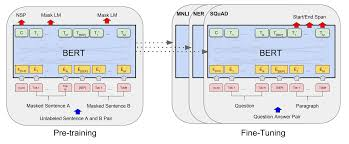</img>



The full block diagram of internal layers of the Bert model is shown here:

<img src="https://miro.medium.com/max/876/0*ViwaI3Vvbnd-CJSQ.png"></img>

In [ ]:
#Step 5.
# First load the real tokenizer- Bert
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:

train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=2017)
print(train_set.shape)
print(test_set.shape)

In [ ]:
#Step 5.
#Tokenize the datasets
train_x = fast_encode(train_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
val_x = fast_encode(test_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
train_y=train_set['target'].values
val_y=test_set['target'].values
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)


In [ ]:
#Step 6.
#Create Tensorflow Datasets
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_x, train_y))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_x, val_y))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

print(train_dataset)
print(valid_dataset)

In [ ]:
#Step 7.
#Build the transformer model
with strategy.scope():
    transformer_layer = (
        transformers.TFBertModel
        .from_pretrained('bert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
#Step 8.
#Train the model

n_steps = train_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
#Step 9.
#Validate the model

n_steps = val_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)


## Analyse the Albert Model

Now with the performance of Bert with us, we will be analysing the Albert model for our use case.
For this, we will use the Albert Model from HuggingFace Transformers

In [ ]:
#Step 5.
# First load the real tokenizer- Bert
tokenizer = transformers.AlbertTokenizer.from_pretrained('albert-base-v1')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:

train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=2017)
print(train_set.shape)
print(test_set.shape)

In [ ]:
#Step 5.
#Tokenize the datasets
train_x = fast_encode(train_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
val_x = fast_encode(test_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
train_y=train_set['target'].values
val_y=test_set['target'].values
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)


In [ ]:
#Step 6.
#Create Tensorflow Datasets
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_x, train_y))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_x, val_y))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

print(train_dataset)
print(valid_dataset)

In [ ]:
#Step 7.
#Build the transformer model
with strategy.scope():
    transformer_layer = (
        transformers.TFAlbertModel
        .from_pretrained('albert-base-v1')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
#Step 8.
#Train the model

n_steps = train_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
#Step 9.
#Validate the model

n_steps = val_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)


## Some other Transformers

There are several transformers we can use for our use cases. We will be focussing on  more such transformer architectures.
The first one is GPT (OpenAI) and the second is BART (Facebook).

GPT(Generative Pre-training) is a SOTA for generative (transfer learning) based architecture which has achieved great heights with its new language models (GPT2/3). We will be analysing the performance of GPT-2 for our use case. Some important resources on GPT-2:

1. [GPT-2](https://openai.com/blog/better-language-models/)
2. [HuggingFace GPT-2](https://huggingface.co/transformers/model_doc/gpt2.html)

We will also be looking into BART, which is another improvisation by Facebook,done by using Bert's left to right encoder and GPT's right to left decoder. Some resources on this can be found at:

1. [BART](https://huggingface.co/transformers/model_doc/bart.html)
2. [Paper](https://arxiv.org/abs/1910.13461)

For our usecases, we will just follow the steps from before and build these models on our corpuses. 
Since BART is incompatible with Tensorflow yet, we can try it using Pytorch.
Another Transformer architecture which is important is TransformerXL:

1. [TransformerXL](https://huggingface.co/transformers/model_doc/transformerxl.html)
2. [Paper](https://arxiv.org/abs/1901.02860)

This covers most of the famous architectures in the Transformer space. A comparative analysis between Bert and Gpt model can be found here:

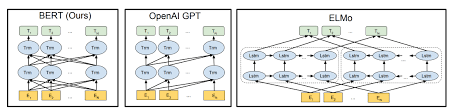</img>

## GPT-2 Transformer

Here we analyse the GPT-2 Transformer for our use case.

The pathway for self attention in GPT-2 is shown here:

<img src="https://jalammar.github.io/images/gpt2/gpt2-self-attention-split-attention-heads-1.png"></img>

In [ ]:
#Step 5.
# First load the real tokenizer- GPT-2
tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2-medium')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:

train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=2017)
print(train_set.shape)
print(test_set.shape)

In [ ]:
#Step 5.
#Tokenize the datasets
train_x = fast_encode(train_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
val_x = fast_encode(test_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
train_y=train_set['target'].values
val_y=test_set['target'].values
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)


In [ ]:
#Step 6.
#Create Tensorflow Datasets
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_x, train_y))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_x, val_y))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

print(train_dataset)
print(valid_dataset)

In [ ]:
#Step 7.
#Build the transformer model
with strategy.scope():
    transformer_layer = (
        transformers.TFGPT2Model
        .from_pretrained('gpt2-medium')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
#Step 8.
#Train the model

n_steps = train_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
#Step 9.
#Validate the model

n_steps = val_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)


## Analyse the BART Transformer

Here we will now  analyse the BART Transformer and check its performance with respect to other transformers.
However BART from HuggingFace is not compatible with Tensorflow yet. We should use Pytorch as our framework for training BART.

A preview is shown here:

<img src="https://www.programmersought.com/images/833/4ff45b63f9b61a1cc178dc89f356f0c9.JPEG"></img>


Bart uses pretrained encoders to evaluate against the current encodings and validates them before passing in to the transformer network.

In [ ]:
#Step 5.
# First load the real tokenizer- BART
tokenizer = transformers.BartTokenizer.from_pretrained('facebook/bart-base')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:

train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=2017)
print(train_set.shape)
print(test_set.shape)

In [ ]:
#Step 5.
#Tokenize the datasets
train_x = fast_encode(train_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
val_x = fast_encode(test_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
train_y=train_set['target'].values
val_y=test_set['target'].values
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)


In [ ]:
#Step 6.
#Create Tensorflow Datasets
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_x, train_y))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_x, val_y))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

print(train_dataset)
print(valid_dataset)

## Bart (HuggingFace) is incompatible with Tensorflow (for now!)

So for this, we just need to plug in the Bart tokenizer with any pre-trained model, for instance Albert to form a composite architecture. This is sometimes refered to as an ensemble Transformer architecture.

In [ ]:
#Step 7.
#Build the transformer model- Bart tokenizer + ALbert model
with strategy.scope():
    transformer_layer = (
        transformers.TFAlbertModel
        .from_pretrained('albert-base-v1')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
#Step 8.
#Train the model

n_steps = train_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
#Step 9.
#Validate the model

n_steps = val_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)


## The Transformer XL Architecture

This is another transformer and should be analysed as well. All of the transformers covered are SOTA in their respective tasks and anyone can be used based on certain use cases.

A good analysis between GPT/BERT/Transformer-XL is provided here:

<img src="https://jalammar.github.io/images/gpt2/gpt-2-transformer-xl-bert-3.png"></img>

In [ ]:
#Step 5.
# First load the real tokenizer- BART
tokenizer = transformers.TransfoXLTokenizer.from_pretrained('transfo-xl-wt103')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:

train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=2017)
print(train_set.shape)
print(test_set.shape)

In [ ]:
#Step 5.
#Tokenize the datasets
train_x = fast_encode(train_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
val_x = fast_encode(test_set['question_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
train_y=train_set['target'].values
val_y=test_set['target'].values
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)


In [ ]:
#Step 6.
#Create Tensorflow Datasets
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_x, train_y))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_x, val_y))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

print(train_dataset)
print(valid_dataset)

In [ ]:
#Step 7.
#Build the transformer model- Bart tokenizer + ALbert model
with strategy.scope():
    transformer_layer = (
        transformers.TFTransfoXLModel
        .from_pretrained('transfo-xl-wt103')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
#Step 8.
#Train the model

n_steps = train_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
#Step 9.
#Validate the model

n_steps = val_x.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)


## Conclusion for Transformers For Industrial Use case

This concludes the several SOTA Transformers for our usecase and this can also be used for any classification tasks as well.
In the next section, let us build a custom transformer to understand the architectures in depth along with the Attention mechanism

This image shows the variation of Transformer architectures for different NLP tasks from classification to question anwering:

<img src="http://jalammar.github.io/images/openai-input%20transformations.png"></img>

Please follow the excellent resources:

1. [Transfer Learning in Transformers](http://jalammar.github.io/illustrated-bert/)
2. [GPT-2 Enhanced Architecuture](http://jalammar.github.io/illustrated-gpt2/)
3. [Current SOTA GPT-3](http://jalammar.github.io/how-gpt3-works-visualizations-animations/)


# Creating a Custom Transformer

This section will help us in understanding the concepts required for creating a custom transformer.
The most important paper for this is present in the [link](https://paperswithcode.com/paper/attention-is-all-you-need) . It was written by Vaswani etal from Google research and is the paper which started the transformer journey.

<img src="https://miro.medium.com/max/744/1*abz_nltyDYtC6ThqNg4O6w.png"></img>

Transformers alleviate the use of Convolution or Recurrent Networks by replacing them with attention mechanisms. This is because of the need for parallelization in training as well as to remove recurrence units. Seq2seq transduction models like the ones shown yesterday rely on something called as a Encoder-Decoder architecture. 

The encoder architecture consists of stacked LSTM cells which control and give access to the memory for storing latent features. The decoder is responsible for extracting the outputs from the topmost stacked LSTM cell. While this is a good strategy over traditional models, it gets affected by catastrophic forgetting. 

Some excellent sources for understanding seq2seq encoder-decoder model are:

1. [Jason's blog](https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/)
2. [Francois Chollet's Code](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)

From the encoder -decoder architecture arose the need for memory persistent attention units.
The first paper on attention was provided by Bahdanau for [Neural Machine Translation](https://paperswithcode.com/paper/neural-machine-translation-by-jointly).


A comparative analysis between Bahdanau Attention and Luong Attention is provided here:

<img src="https://miro.medium.com/max/1000/1*BfwFEH4tgY-JwHxr-2D2KQ.png"></img>

Neural Machine Translation is an entire different area of research which also uses Encoder decoder architectures coupled with attention mechanisms. A diagram of how this happens is provided below:

<img src="http://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png"></img>

## Encoder Decoder Architectures

These architectures are inherent in every transformer. Both of them are effectively similar deep learning models which are used to storing and abstracting data mainly consisting of LSTM units. The block diagram is provided:

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/10/Encoder-Decoder-Architecture-for-Neural-Machine-Translation.png"></img>


There are different embeddings which are present in both of them (encoder and decoder). The input to the encoder layer is tokenized and then passed in to the positional embeddings layer. Then these are passed into the Deep Learning layers (mostly CNN/LSTM) . Then these are passed through the Attention module which performs tensor computations to assign more weights to certain words in the input (encoded) sentence. These are then passed in to the decoder unit.

During indference, the decoder uses the mapping of the attention weights of certain important words to get the correct probabilities of the output words. Essentially the activation used in totality is the softmax as it has been employed across every embedding algorithm ,which relies on joint probability distribution of a word with respect to other words in the sentence.

## Self Attention in Depth

Self Attention relies on certain vectors q(query),k(key) and v(value). The vectors q and k are multiplied together and divided by 8(according to the papers) and then passed through a normalized softmax activation unit. This is donw so as to retain the memory of the weights when they are transferred from the encoder to the decoder layer. A series of images help us understand this:

<img src="http://jalammar.github.io/images/t/transformer_self_attention_vectors.png"></img>

This is how the operation is executed:

<img src="http://jalammar.github.io/images/t/self-attention-output.png"></img>


The entire Self Attention is done multiple times to get Multi-Head Attention which aids in parallel computing of the weights of the attention layers:

<img src="http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png"></img>

This excellent resource from [Jalammar](http://jalammar.github.io/illustrated-transformer/) is highly recommended.

## Layer Normalization after Multi Headed Self Attention

Layer normalization is an important measure to maintain the mean and variance of each layer. It has its similarities with batch normalization in normal neural networks, but with certain [changes](http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png).

The entire Encoder architecture involving Layer Norm and Self Attention for Transformers is  represented here:

<img src="http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png"></img>

## Creating a Transformer With Keras

A mini transformer with  multi headed attention mechanism from keras for our use cases.

For this we will be needing a masked Multi Head self attention.The effect of masking in Attention is provided in the image:

<img src="http://jalammar.github.io/images/gpt2/self-attention-and-masked-self-attention.png"></img>

## Resources for Transformers

Some of the resources which helped to create this:

1. [Tensorflow Implementation-Google Brain](https://github.com/tensorflow/models/tree/master/official/nlp/transformer)
2. [Excellent Resource](https://github.com/Lsdefine/attention-is-all-you-need-keras/blob/master/transformer.py)
3. [Tensor2Tensor from Google](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)

These will be helpful for analysing with other resources provided.

In [ ]:
#Creating the inputs features
train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=2017)
print(train_set.shape)
print(test_set.shape)

In [ ]:
#Codes from day-1
maxlen=1000
max_features=5000 
embed_size=300

#clean some null words or use the previously cleaned & lemmatized corpus

train_x=train_set['question_text'].fillna('_na_').values
val_x=test_set['question_text'].fillna('_na_').values

#Tokenizing steps- must be remembered
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_x))
train_x=tokenizer.texts_to_sequences(train_x)
val_x=tokenizer.texts_to_sequences(val_x)

#Pad the sequence- To allow same length for all vectorized words
train_x=pad_sequences(train_x,maxlen=maxlen)
val_x=pad_sequences(val_x,maxlen=maxlen)


#get the target values - either using values or using Label Encoder
train_y=train_set['target'].values
val_y=test_set['target'].values


In [ ]:
#Codes from Day-1
EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


## Building the actual Model

In this case, here are the following parts of the model:

1. Add a Layer Normalization Layer
2. Create a function/class for Self Attention
3. Join different Self Attention objects together to get Multi Head Attention
4. 

In [ ]:
import random, os, sys
import numpy as np
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass

#Layer normalization class
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        #Adding custom weights
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

#Division by 8 (q.k/d^0.5)
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        #Joining scaled dot product
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        outputs = Add()([outputs, q])
        return self.layer_norm(outputs), attn
#Feedforward layer using COnv1D and Layer normalization.
class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)
#Encoder layer containing self/multi head attention with positionwisefeedforward
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
#Decoder layer with same architecture as the encoder.
class DecoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_att_layer  = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, dec_input, enc_output, self_mask=None, enc_mask=None):
        output, slf_attn = self.self_att_layer(dec_input, dec_input, dec_input, mask=self_mask)
        output, enc_attn = self.enc_att_layer(output, enc_output, enc_output, mask=enc_mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn, enc_attn
#This is from the paper "Attention is all you need" which hypothesizes sin and cosine for positional encoding
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

#normal padding class for masking
def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Encoder():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, \
                layers=6, dropout=0.1, word_emb=None, pos_emb=None):
        self.emb_layer = word_emb
        self.pos_layer = pos_emb
        self.emb_dropout = Dropout(dropout)
        self.layers = [EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout) for _ in range(layers)]
        
    def __call__(self, src_seq, src_pos, return_att=False, active_layers=999):
        x = self.emb_layer(src_seq)
        if src_pos is not None:
            pos = self.pos_layer(src_pos)
            x = Add()([x, pos])
        x = self.emb_dropout(x)
        if return_att: atts = []
        mask = Lambda(lambda x:GetPadMask(x, x))(src_seq)
        for enc_layer in self.layers[:active_layers]:
            x, att = enc_layer(x, mask)
            if return_att: atts.append(att)
        return (x, atts) if return_att else x


class Transformer():
    def __init__(self, len_limit, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = True
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None,))
        src_seq = src_seq_input
        src_pos = Lambda(self.get_pos_seq)(src_seq)
        if not self.src_loc_info: src_pos = None

        x = self.encoder(src_seq, src_pos, active_layers=active_layers)
        # x = GlobalMaxPool1D()(x) # Not sure about this layer. Just wanted to reduce dimension
        x = GlobalAveragePooling1D()(x)
        outp = Dense(1, activation="sigmoid")(x)

        self.model = Model(inputs=src_seq_input, outputs=outp)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
seq2seq = Transformer(maxlen, layers=1)
seq2seq.compile()
model = seq2seq.model

In [ ]:
# Evaluate and Train the Model

model.fit(train_x, train_y, batch_size=1024, epochs=1, validation_data=(val_x, val_y))

## Some important resources from Github

Here are some important resources which will definitely help.

1. [BERT:Google Research](https://github.com/google-research/bert)
2. [Dale's notebook](https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb)
3. [Albert](https://github.com/google-research/albert)
4. [GPT-2](https://github.com/openai/gpt-2)
5. [Roberta](https://github.com/pytorch/fairseq/tree/master/examples/roberta)
6. [Bart](https://github.com/pytorch/fairseq/tree/master/examples/bart)
7. [Transformer-XL](https://github.com/kimiyoung/transformer-xl)
8. [Hugging Face Transformers](https://github.com/huggingface/transformers)


These resources should help. Apart from this, for more details on attention mechanism (for now only Hierarchical) you can refer to [my repo](https://github.com/abhilash1910/MiniAttention). I will be adding more custom attention modules which can be used any sequential network, including a separate transformer architecture. 

## Graph Learning

There is another paradigm in NLP which relies on Deep Learning in Graphs, which is beyond today's session. Just as an overview, all the architectures/models which we have built are also applicable for knowledge graphs. These are essentially in huge corpuses of data such as Google search, where scalable transformer architectures are employed on graphs. All social media (twitter,facebook etc) rely on extensive large scale graph transformer networks for classification, question answering, semantic indexing, reference resolution, masking and generative modelling.

# Conclusion

This completes today's session and the entire workshop in totality.
Would appreciate feedbacks as well as follow-ups. Follow me on [github](https://github.com/abhilash1910) for any updates on deep learning or NLP!